# Image Offsets: Process sequence

This notebook transforms the procedures developed in `Offsets_1.ipynb` into callable functions. 

These functions are used in a loop to process an entire sequence of images. Results are later examined in plots. 

The end product is a series of FITS tables, one per input image, that contain the star offsets in relation to the reference image. These tables should be used in a subsequent notebook to generate the actual arrays with pixel offsets that are used by drizzle to figure out the pixel mapping.

In [1]:
# %pylab notebook
# %matplotlib notebook

import time

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from photutils import centroids
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy
import exifread

from datapath import DATA

/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_6306/3147480647.py:17: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture
/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_6306/3147480647.py:17: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture
/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_6306/3147480647.py:17: DeprecationWarning: `photutils.ModeEstimatorBa

## Initialization

Define values to be used in the processing functions, and throughout the script.

In [2]:
dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
# dirpath = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/3200/light/')
file_list = glob.glob(dirpath + '/*.ARW')

In [3]:
# normalization factors to get the roundest star images (as per Offsets_1 notebook)
red_norm = 1.6  
blue_norm = 1.39

# parameters to control background subtraction
bkg_cell_footprint = (100, 100)
bkg_filter = (11, 11)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=1)
bkg_estimator = ModeEstimatorBackground()

# parameters for star finding
dao_fwhm = 5.
dao_threshold = 2000.
sharplo = 0.1
sharphi = 1.0
roundlo = -0.9 
roundhi = 0.9

proximity = 2.5

In [4]:
# 1st test image - this will be the reference image which subsequent images
# will have their offsets computed against. We need to read it here to get 
# the camera color array specification as well.
fname = file_list[0]
raw = rawpy.imread(fname)
ref_imarray = raw.raw_image_visible.astype(float)

In [5]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

Using normalizations derived from passband spectral response is *much* better than using normalizations derived from minimization of sky background variance (contrary to the initial finding in notebook Offsets_1). The likely cause is that the spectral-based normalization creates more well-behaved star images. The high variance in sky background doesn't seem to get in the way of detecting stars.

The best run with smooth background on the ISO 12800 data generated 240 detections with a complete data set. The same run but with spectral-based color band normalizations resulted in 550 detections.

## Processing functions

In [6]:
# computes position offsets between two tables. 
def get_offsets(sources, sources_prev):

    sources.add_column(np.nan, name='xoffset')
    sources.add_column(np.nan, name='yoffset')
    sources.add_column(0.0, name='xoffset_prev')
    sources.add_column(0.0, name='yoffset_prev')
    sources.add_column(0, name='ref_row')
    sources.add_column(0, name='prev_row')

    # loop over rows in previous table
    for row_index_prev in range(len(sources_prev)):
        # index in reference table
        ref_row = sources_prev[row_index_prev]['ref_row']

        # if previous table does not contain a pointer to 
        # the reference table, ignore.
        if ref_row == 0:
            continue

        # get position in previous table
        x_prev = sources_prev[row_index_prev]['xcentroid']
        y_prev = sources_prev[row_index_prev]['ycentroid']

        # loop over rows in current table
        for row_index in range(len(sources)):
            x = sources[row_index]['xcentroid']
            y = sources[row_index]['ycentroid']

            # offsets in relation to previous table - these are the ones to check for proximity
            x_off_previous = x - x_prev
            y_off_previous = y - y_prev

            # check for proximity, and store relevant info if found
            if abs(x_off_previous) <= proximity and abs(y_off_previous) <= proximity:

                # offsets in relation to reference table
                sources[row_index]['xoffset'] = x - sources_ref[ref_row]['xcentroid']
                sources[row_index]['yoffset'] = y - sources_ref[ref_row]['ycentroid']

                # offsets in relation to previous table
                sources[row_index]['xoffset_prev'] = x_off_previous
                sources[row_index]['yoffset_prev'] = y_off_previous

                # store pointers to rows in reference and previous tables
                sources[row_index]['ref_row'] = ref_row
                sources[row_index]['prev_row'] = row_index_prev
                
                #TODO 
                # instead of breaking, do an estimate of where the centroid would be,
                # given the current position, and the offsets from the previous table.
                # In other words, repeat the offset from the previous table. See if this
                # will cause the finding algorithm to pick up in the next image.

                break # if there is another star that matches the criterion, just ignore it
                
    return sources

In [7]:
def subtract_background(imarray, red_norm=1.0, blue_norm=1.0):

    # red_norm and blue_norm are normalization parameters applied to the R and B bands (assume
    # G=1) in order to make the star images as well-behaved as possible, in terms of being 
    # well represented, on average, by the daofind Gaussian. Ideally a different normalization 
    # should be applied to each star, depending on its color index, but this will be left as
    # a possible (but not very likely) future improvement. For now, we assume that an average,
    # frame-wide single normalization should suffice (statistically).
    
    # separate color bands
    red_array = imarray * red_mask
    green_array = imarray * green_mask
    blue_array = imarray * blue_mask
    
    # interpolate over the masked pixels in each band, so the background estimator 
    # is presented with a smooth array entirely filled with valid data
    red_array[red_array == 0.0] = np.nan
    green_array[green_array == 0.0] = np.nan
    blue_array[blue_array == 0.0] = np.nan

    red_array = interpolate_replace_nans(red_array, bkg_kernel)
    green_array = interpolate_replace_nans(green_array, bkg_kernel)
    blue_array = interpolate_replace_nans(blue_array, bkg_kernel)

    red_array[np.isnan(red_array)] = 0.
    green_array[np.isnan(green_array)] = 0.
    blue_array[np.isnan(blue_array)] = 0.
    
    # fit background model to each smoothed-out color band
    red_bkg = Background2D(red_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    green_bkg = Background2D(green_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    blue_bkg = Background2D(blue_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

    # subtract background from each masked color array
    subtracted = imarray - red_bkg.background * red_mask - \
                           green_bkg.background * green_mask - \
                           blue_bkg.background * blue_mask

    # after background subtraction, apply color band normalization. This has to be done separately
    # from step above for the background on each band to remain zero on average.
    subtracted = (subtracted * red_mask * red_norm) + \
                 (subtracted * green_mask) + \
                 (subtracted * blue_mask * blue_norm)

    return subtracted

In [8]:
class CentroidFinder():
    def __init__(self, x_estimate, y_estimate, size, sky, threshold):
        self.x_estimate = x_estimate
        self.y_estimate = y_estimate
        self.sky = sky
        self.threshold = threshold
        self.size = int(size)
        
        self.result = Table()
        
    def find(self, image):
        x, y = centroids.centroid_sources(image, self.x_estimate, self.y_estimate, 
                                          box_size=self.size, centroid_func=centroids.centroid_com)                

        self.result.add_column(x, name='xcentroid')
        self.result.add_column(y, name='ycentroid')

        return self.result                

In [9]:
# creates a table with star positions, given a path to an image file
def find_stars(path, sources_prev=None):

    with rawpy.imread(path) as raw:
        imarray = raw.raw_image_visible.astype(float)

        subtracted = subtract_background(imarray, red_norm=red_norm, blue_norm=blue_norm)
        
        global_median = np.median(subtracted)
        
        # find stars
        if sources_prev is None:
            daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                                    sharplo=sharplo, sharphi=sharphi,
                                    roundlo=roundlo, roundhi=roundhi) 
            sources = daofind(subtracted)
        else:
            # offsets are added in reverse, to generate an estimate further away from the current position.
            x_estimate = sources_prev['xcentroid'] - sources_prev['xoffset_prev'] 
            y_estimate = sources_prev['ycentroid'] - sources_prev['yoffset_prev'] 

#             positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]
#             daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                                     sky=global_median,
#                                     threshold=dao_threshold,
#                                     sharplo=sharplo, sharphi=sharphi,
#                                     roundlo=roundlo, roundhi=roundhi) 
#             sources = daofind(subtracted)

            try:
                finder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2+1, global_median, dao_threshold)
                sources = finder.find(subtracted)
            except ValueError:
                # should prevent errors of type "xpos, ypos values contains point(s) outside of input data"
                x_estimate = sources_prev['xcentroid'] 
                y_estimate = sources_prev['ycentroid']  
                finder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2+1, global_median, dao_threshold)
                sources = finder.find(subtracted)
                
    return sources, subtracted, global_median

In [10]:
# keep only the NaN-free entries
def clean_nans(sources):
    has_nan = np.zeros(len(sources), dtype=bool)
    xoff = np.array(sources['xoffset'])
    has_nan |= np.isnan(xoff)
    return sources[~has_nan]

## Process sequence

In [11]:
# find stars in reference image
file_list.sort()
sources_ref, subtracted_ref, global_median = find_stars(file_list[0])

# positions storage
positions_tables = {}
positions_tables[file_list[0]] = sources_ref

# array for stacking subtracted images
image_stack = np.zeros_like(subtracted_ref)

# add default offset columns to reference table
sources_ref.add_column(0., name='xoffset')
sources_ref.add_column(0., name='yoffset')
sources_ref.add_column(0., name='xoffset_prev')
sources_ref.add_column(0., name='yoffset_prev')

# in ref table, rows point to themselves
sources_ref.add_column(sources_ref['id']-1, name='ref_row')
sources_ref.add_column(sources_ref['id']-1, name='prev_row')

# force reference image to be the "previous" image
sources_prev = sources_ref

sources_ref

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
1,2419.2178391286448,15.03002047721238,0.7345235337599373,-0.04404923250268031,0.13195001463582645,49,-2.9118643461945344,3752.629075156021,145.41232949741575,-5.406503079678876,0.0,0.0,0.0,0.0,0,0
2,63.63599081366581,29.048441012641984,0.713108028004283,-0.20463902991394822,-0.3943528063188875,49,-2.9118643461945344,3623.0153425626995,144.80075501862598,-5.40192706590227,0.0,0.0,0.0,0.0,1,1
3,1680.6845183112323,34.97434185498487,0.880496844577952,0.4923269713432562,0.08996170766693082,49,-2.9118643461945344,2267.103803336118,144.05858322483533,-5.396347848247628,0.0,0.0,0.0,0.0,2,2
4,1750.5188004140869,36.38815233054337,0.6275981760681065,0.45523398539586385,0.1340838447284362,49,-2.9118643461945344,1300.701331315822,143.70284065658475,-5.393663382918832,0.0,0.0,0.0,0.0,3,3
5,4145.024969885967,42.99921704884187,0.8761444776134345,-0.40262923746968365,-0.020875385591967513,49,-2.9118643461945344,1741.9245506972588,143.76555305800625,-5.394137098480469,0.0,0.0,0.0,0.0,4,4
6,1854.9773561738725,49.727526213835816,0.8064692085301869,0.5365955620130362,0.3135592597028047,49,-2.9118643461945344,5851.923362423391,146.53224692914267,-5.4148330228565325,0.0,0.0,0.0,0.0,5,5
7,2815.968049327324,71.59943856897685,0.5970756571808266,-0.2072159162110672,0.07916146676973482,49,-2.9118643461945344,2076.539986181114,144.44769259359177,-5.3992765220466925,0.0,0.0,0.0,0.0,6,6
8,1628.8355724808307,75.89043375577138,0.7135560599933766,0.7166034710666201,0.13023290414696576,49,-2.9118643461945344,2408.3218981576597,144.4175457425011,-5.399049900608986,0.0,0.0,0.0,0.0,7,7
9,1677.2620513423938,116.57190574377351,0.5013176645393611,0.47979665999006077,0.21611472327201353,49,-2.9118643461945344,1726.3700370525698,144.30161775730323,-5.398177999929361,0.0,0.0,0.0,0.0,8,8


In [12]:
sources_prev = sources_ref

# loop over list of remaining images
for file_path in file_list[1:]:
    
    # find stars
#     t1 = time.time()
    sources, subtracted, global_median = find_stars(file_path, sources_prev=sources_prev)
#     t2 = time.time()
#     print("find stars: " , (t2-t1), " sec.")
    
    # compute offsets
#     t1 = time.time()
    sources_current = get_offsets(sources, sources_prev)
#     t2 = time.time()
#     print("get offsets: " , (t2-t1), " sec.")
    
    sources_current_no_nan = clean_nans(sources_current)
    
    positions_tables[file_path] = sources_current_no_nan
    
    # save table to file
    
    # for next iteration, current table becomes previous
    sources_prev = sources_current_no_nan
    
    # update image stack
    image_stack += subtracted
    
    print(file_path, len(sources_current_no_nan), global_median)

/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.ARW 434 -2.8534033310874634
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.ARW 434 -2.820350376821094
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.ARW 432 -2.9000951307488325
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.ARW 429 -2.8438337665425593
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.ARW 427 -2.9279939821066137
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.ARW 427 -2.910395843029613
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.ARW 427 -2.9156089108322476
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03778.ARW 427 -2.91935011792

In [13]:
sources_current_no_nan

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
1630.9768299044215,43.09972094250331,-49.7076884068108,8.12537908751844,-1.2035088021650608,0.002971307509078258,2,0
1700.9816654717,44.63528335076187,-49.537134942386956,8.247131020218497,-1.4906653434813961,1.0789380595600875,3,1
1806.531440109423,56.52669227781844,-48.44591606444942,6.799166063982625,-0.7281359836786123,0.1274959914829168,5,2
2764.439447752646,69.6063328593799,-51.52860157467785,-1.9931057095969464,-0.7709841892369695,0.10874278704523022,6,3
1580.0126797901557,84.33510317917664,-48.82289269067496,8.444669423405259,-0.7339237093274278,0.03340568421600665,7,4
1628.662902006418,125.17362804589145,-48.59914933597565,8.601722302117935,-1.36084229114158,0.37173430701092514,8,5
2003.4837086881605,137.3772052444409,-46.30557407750916,4.800114330721158,-0.7412578468643005,0.1409325508560073,10,6
1993.814469561847,139.7775702639233,-46.90840235851465,5.042394118367696,-1.101522721090305,0.3635728338187221,11,7
2204.7333378667036,151.35739685182375,-46.60151791740191,2.7671725510498106,-0.8367789757644459,0.05387193950136293,12,8


In [14]:
# positions = [(x,y) for x,y in zip(sources_current_no_nan['xcentroid'], sources_current_no_nan['ycentroid'])]
# positions_ref = [(x,y) for x,y in zip(sources_ref['xcentroid'], sources_ref['ycentroid'])]

# apertures = CircularAperture(positions, r=5.)
# apertures_ref = CircularAperture(positions_ref, r=5.)

# plt.figure(figsize=[9, 6])
# plt.imshow(image_stack, vmin=-10, vmax=10000, cmap='binary')
# plt.colorbar()
# _ = apertures.plot(color='red')
# _ = apertures_ref.plot(color='yellow')

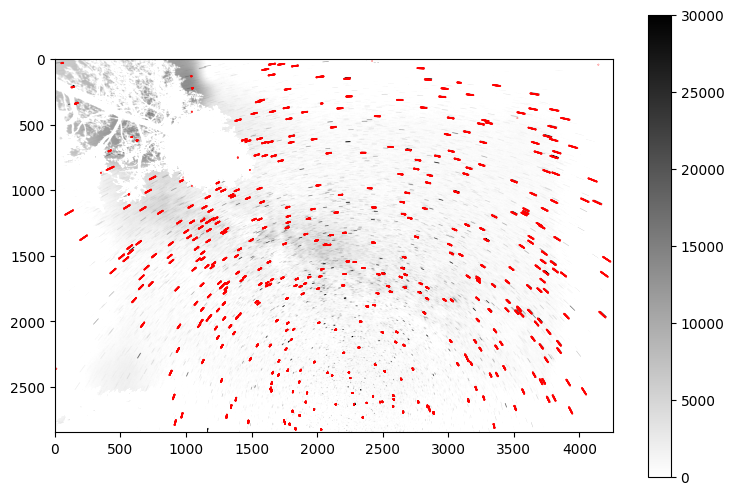

In [15]:
plt.figure(figsize=[9, 6])
plt.imshow(image_stack, vmin=-10, vmax=30000, cmap='binary')
plt.colorbar()

for file_path in list(positions_tables.keys()):
    positions_t = positions_tables[file_path]
    positions = [(x,y) for x,y in zip(positions_t['xcentroid'], positions_t['ycentroid'])]
    apertures = CircularAperture(positions, r=1.)
    _ = apertures.plot(color='red')

## Plot only complete sequence stars

Stars with a complete sequence of measured centroids are the ones that make to the last image/table in the sequence. Thus, starting from the end image and going backwards, we ensure we pick only the complete sequence stars.

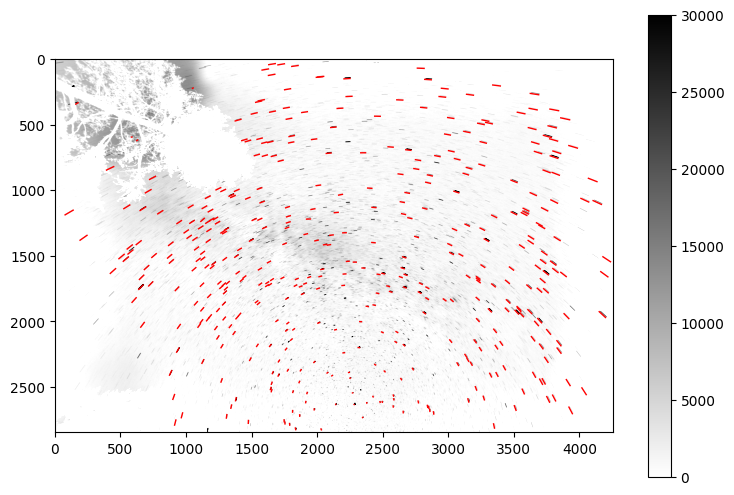

In [16]:
# start from last table in sequence 
file_path_last = list(positions_tables.keys())[-1]
positions_last = positions_tables[file_path_last]
refrow_last = positions_last['ref_row']

file_path_first = list(positions_tables.keys())[0]  # ref table
positions_first = positions_tables[file_path_first]

plt.figure(figsize=[9, 6])
plt.imshow(image_stack, vmin=-10, vmax=30000, cmap='binary')
plt.colorbar()

for i, row in enumerate(refrow_last):
    ref_row = positions_first[row]
    
    x0 = ref_row['xcentroid']
    y0 = ref_row['ycentroid']
    x1 = positions_last['xcentroid'][i]
    y1 = positions_last['ycentroid'][i]
    
    plt.plot([x0,x1], [y0,y1], 'r', linewidth=1, markersize=1)

## Write tables

In [17]:
from astropy.io import fits

keys = list(positions_tables.keys())

for key in keys:
    dirname = os.path.dirname(key)
    fname = os.path.basename(key)
    imagename = fname.split('.')[0]
    tablename = os.path.join(dirname, imagename + '.offsets_table.fits')
    
    table = positions_tables[key]
    
    table.write(tablename, overwrite=True)

    print(tablename)

/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.offsets_table.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/Milky